In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:

#Import local database interface 
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from Database.ca_mysqldb import MySQLConnector


In [3]:
def queryDB(columns, *args):
    query = "SELECT "
    for col in columns:
        query += col + ", "
    query = query[:-2] # remove last comma
    query += " FROM ca_courseware.Video_Events"
    if(args):
        query += " LIMIT " + str(args[0])

    db = MySQLConnector()
    out = db.execute(query)
    db.close()
    if "*" in columns:
        return pd.DataFrame.from_records(out)
    else:
        return pd.DataFrame.from_records(out, columns=columns)    

In [16]:

db = MySQLConnector()
out = db.execute("show databases")
print(out)
db.close()


[('ca_courseware',), ('information_schema',), ('project_himanshu',)]


In [9]:
df = queryDB(["*"], 1000)


<h2 id="MOOC-Exploratory-Analysis">MOOC Exploratory Analysis<a class="anchor-link" href="#MOOC-Exploratory-Analysis">¶</a></h2><p>In this notebook, we seek to do exploratory analysis with MOOC data from an introductory analysis course at EPFL. We will draw upon exiting research and try to apply it in the context of MOOCs. This notebook will be split into four sections:</p>
<ol>
<li>Data Exploration</li>
<li>Feature Processing</li>
<li>Feature Engineering</li>
<li>Model Selection and Discussion</li>
</ol>



<h3 id="Data-Exploration">Data Exploration<a class="anchor-link" href="#Data-Exploration">¶</a></h3><p>Let us understand the given MOOC data and preprocess it to allow for more detail analysis</p>


In [10]:

df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,000004aff95adcd3100223d4c1f5122d,Video_Events,EPFL-suivi-eco-2018_T1,1643,None,None,1516871401,Video.Pause,Browser,c3abc81769f66fda87ee829792f2c153,833a0876c3dc4ba4b28a344bb5576512,None,NaN,120.181,NaN,NaN,NaN
1,000004f0a0dd56979d84b810d92b914e,Video_Events,EPFL-ChoiceModels-2019,102526,None,None,1580218324,Video.Transcript.Translate.EN,Server,ea53c0d1d46955f92e65294532e755e4,d5f1c777c5ac42eaa76f74bc550bd842,None,NaN,NaN,NaN,NaN,NaN
2,0000058abd30591444eca90fe94069cc,Video_Events,EPFL-suivi-eco-2018_T2,29399,None,None,1525126351,Video.Load,Browser,ce802b36da3fa135521c151f309e07f2,10401befca154a1582875bcefa60b9c7,None,NaN,NaN,NaN,NaN,NaN
3,000009a8727edd8668f140f764c0e54e,Video_Events,EPFL-analyse-numerique-2020,133572,None,None,1581929009,Video.Pause,Browser,5f72e35a1339342b19e677ade1631e33,e3e77a4df4bc4f83906dc12e5bdcedc9,None,NaN,290.017,NaN,NaN,NaN
4,00000d25ee4a430ab4ba578d7b7da4d6,Video_Events,EPFL-aires-protegees-2018_T2,32081,None,None,1524665574,Video.Load,Browser,621c6bf6c464591fc58125af3c4a1e61,f29327abdee247efb7d1313ac2cbef5c,None,NaN,NaN,NaN,NaN,NaN


In [13]:
df[df["EventType"].isin(["Video.Pause","Video.Load"])].head()

,VideoID,EventType
0,833a0876c3dc4ba4b28a344bb5576512,Video.Pause
2,10401befca154a1582875bcefa60b9c7,Video.Load
3,e3e77a4df4bc4f83906dc12e5bdcedc9,Video.Pause
4,f29327abdee247efb7d1313ac2cbef5c,Video.Load
5,272e9b6cb57748cfa98c4b72b42cd97f,Video.Pause


In [ ]:

## Grade Distribution Plot
grade_df = df[['ID.Anon', 'Final.Grade']]
grade_df = grade_df.drop_duplicates()
grade_df.groupby('Final.Grade').count().plot(kind='bar', title="Grade Distribution")



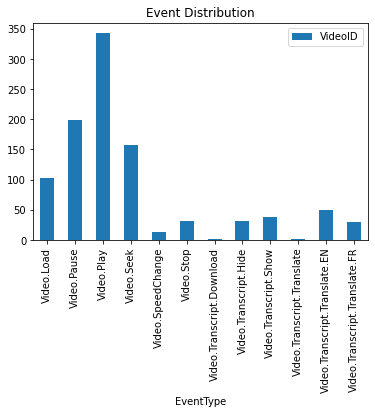

In [34]:

## Event count
df[['EventType', 'VideoID']].groupby('EventType').count().plot(kind='bar', title="Event Distribution")



In [ ]:

## Grade Distribution Plot with Normalised Scores
grade_df = df[['ID.Anon', 'Nor.Score']]
grade_df = grade_df.drop_duplicates()
grade_df.groupby('Nor.Score').count().plot(kind='line', title="Grade Distribution (normalised score)")



In [ ]:

## How many videos did students watch
video_df = df[['ID.Anon', 'Source']].drop_duplicates()
video_df.groupby('ID.Anon').count().plot(kind='hist', bins=[0, 20, 40, 60, 80, 100, 120, 140], rwidth=0.8, title="How many videos did each student watch?")



In [ ]:

## Grades against videos
b = 0
j = 20

db = video_df.groupby('ID.Anon').count().reset_index().rename(columns={'Source': 'Count'})
t = db[db['Count'].between(0, 20)]

df_merge_col = pd.merge(df[['ID.Anon', 'Final.Grade']], t, on='ID.Anon')
np.mean(df_merge_col['Final.Grade'])

avg_grade = []
while b < 140:
    subset = db[db['Count'].between(b, b+j)]
    df_merge_col = pd.merge(df[['ID.Anon', 'Final.Grade']], subset, on='ID.Anon').drop_duplicates()
    avg_grade.append(np.mean(df_merge_col['Final.Grade']))
    b += j

plt.title("Grades based on Videos Watched")
plt.bar(['0-20', '20-40', '40-60', '60-80', '80-100', '100-120', '120-140'], avg_grade)
plt.show()




<p>The data exploration shows that we have a fairly good distribution of final results (from 1.0 to 5.5). However, there is evidently not a good relationship with videos watched. We have students who watched barely any videos with strong grades. We have to preprocess this data further before we can do any form of analysis.</p>



<h3 id="Feature-Processing">Feature Processing<a class="anchor-link" href="#Feature-Processing">¶</a></h3><p>In here we write the functions to form our feature processing pipeline.</p>



<ol>
<li>Create more events (speed down vs speed up , seek back vs seek forward etc.) and drop events which we dont really need (transcript translation etc.)</li>
</ol>


In [ ]:

def drop_and_relabel(df): 
    X = df.copy()
    
    # lets relabel seek events into either seek back or seek forward    
    X.loc[X["OldTime"] > X["NewTime"], "EventType"]  = "Video.SeekBack"
    X.loc[X["OldTime"] < X["NewTime"], "EventType"]  = "Video.SeekForward"
    X = X.loc[X["EventType"] != "Video.Seek"]
    
    # lets relabel speed change into speedup or speed down
    X.loc[X["OldSpeed"] < X["NewSpeed"], "EventType"]  = "Video.SpeedUp"
    X.loc[X["OldSpeed"] > X["NewSpeed"], "EventType"]  = "Video.SpeedDown"
    X = X.loc[X["EventType"] != "Video.SpeedChange"]
    
    # drop unnecessary events
    X = X[X['EventType'] != 'Video.Transcript.Translate.EN']
    X = X[X['EventType'] != 'Video.Transcript.Download']
    X = X[X['EventType'] != 'Video.Transcript.Hide']
    X = X[X['EventType'] != 'Video.Transcript.Show']
    
    return X




<ol>
<li>Drop students who have repeated the course - we consider them outliers as they have engaged with the content once already and watched videos at irregular periods.</li>
</ol>


In [ ]:

# remove repeating students
def remove_repeat(df):
    retook_students = []
    for s in set(df['ID.Anon']):
        x = df[df['ID.Anon'] == s]
        y1 = len(x[x['Course.Year'] == 'Y1-2017-18']) > 0
        y2 = len(x[x['Course.Year'] == 'Y2-2018-19']) > 0
        if y1 and y2:
           retook_students.append(s)

    X = df.copy() 
    for s in retook_students:
        mask = (X['ID.Anon'] == s) & (X['Course.Year'] == 'Y2-2018-19')
        X = X[~mask]
    
    return X




<ol>
<li>Filter students out who have lesser than 60 videos to their names. The student who watched the most videos in our dataset has 139 videos, we try to get the other students to have at least half of this. This means they have engaged with the MOOC platforms and we have something to analyse.</li>
</ol>


In [ ]:

# filter out students with less than 60 videos
def students_with_activity(df):
    vid_df = df[['ID.Anon', 'Source']].drop_duplicates()
    vid_cnt = vid_df.groupby('ID.Anon').count().reset_index().rename(columns={'Source': 'Count'})
    vid_cnt = vid_cnt[vid_cnt['Count'] > 60]
    return pd.merge(left=vid_cnt, right=df, on="ID.Anon").drop_duplicates()




<p><strong>Pipeline</strong>:</p>


In [ ]:

def preprocess(df):
    X = drop_and_relabel(df)
    X = remove_repeat(X)
    X = students_with_activity(X)
    return X




<h2 id="Feature-Engineering">Feature Engineering<a class="anchor-link" href="#Feature-Engineering">¶</a></h2><p>Now that we have our preprocessing pipeline, we can proceed to engineer some features for analysis! This part will be split into two main sections encompassing different thematic ideas.</p>
<ol>
<li>Regularity</li>
<li>Clickstream Behaviour</li>
</ol>



<h2 id="Regularity">Regularity<a class="anchor-link" href="#Regularity">¶</a></h2><p>Q: How does a student's regularity with the MOOC course affect his final grade?</p>
<p>Simply put, regularity can be defined as the number of hours a student engaged with the MOOC videos <strong>during the period in which he or she was supposed to do so</strong>.</p>
<p>For the course which we are analysing, the students only had to do a flipped classroom system for a short period within the semester. This is shown below:</p>
<p><img alt="title" src="img/course.png"/></p>
<p>We understand that the flipped period happened only for a short period in certain years (2017) and may not translate to them necessarily getting good grades. It is also natural for students to have already background or knowledge in the field from other areas.</p>
<p>What we want to understand is: <strong>Student who are more regular tend to me more conscientious about their school work and have better time managemenent. This kind of behaviour should translate to them getting a higher average grade than students who are not. Is this true?</strong></p>



<h3 id="How-can-we-measure-regularity?">How can we measure regularity?<a class="anchor-link" href="#How-can-we-measure-regularity?">¶</a></h3><p>We now have a rough idea of what is regularity but measuring it sounds challenging.</p>
<p>In order to do this, we turn to existing research, namely the paper <a href="https://link.springer.com/chapter/10.1007/978-3-319-45153-4_21">"How to quantify regularity" by Sharma et al in EPFL CHILI lab</a>. The paper derives different measures for regularities and explains their properties. We will be looking at the same properties (albeit with slight modifications).</p>
<p>The measures include:</p>
<table>
<thead><tr>
<th style="text-align:center">Measure</th>
<th style="text-align:center">Description</th>
<th style="text-align:center">Justification</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:center">PDH</td>
<td style="text-align:center">Peak on day hour</td>
<td style="text-align:center">Identifies if a student's activities are centred around a particular hour of the day</td>
</tr>
<tr>
<td style="text-align:center">PWD</td>
<td style="text-align:center">Peak on week day</td>
<td style="text-align:center">Identifies if a student's activities are centred around a particular day of the week</td>
</tr>
<tr>
<td style="text-align:center">WS1/WS2/WS3</td>
<td style="text-align:center">Weekly Similarities in daily activity</td>
<td style="text-align:center">Identifies if student's have similar patterns every week</td>
</tr>
<tr>
<td style="text-align:center">FDH</td>
<td style="text-align:center">Hourly Pattern over days</td>
<td style="text-align:center">Identifies if hourly pattern is repeating over days</td>
</tr>
<tr>
<td style="text-align:center">FWH</td>
<td style="text-align:center">Hourly Pattern over weeks</td>
<td style="text-align:center">Identifies if hourly pattern is repeating over weeks</td>
</tr>
<tr>
<td style="text-align:center">FWD</td>
<td style="text-align:center">Daily Pattern over Weeks</td>
<td style="text-align:center">Identifies if daily pattern is repeating over weeks</td>
</tr>
</tbody>
</table>



<h5 id="Metadata-(course-duration)">Metadata (course duration)<a class="anchor-link" href="#Metadata-(course-duration)">¶</a></h5>


In [ ]:

from datetime import date
import time

# length of course
timing = {
    'Y1-2017-18': {
        'Lw': 6,
        'Start': time.mktime(date(2017, 10, 12).timetuple())
    },
    
    'Y2-2018-19': {
        'Lw': 13,
        'Start': time.mktime(date(2018, 9, 17).timetuple())
    },
}




<h5 id="Helper-Functions">Helper Functions<a class="anchor-link" href="#Helper-Functions">¶</a></h5>


In [ ]:

from datetime import datetime


def convert_to_date(ts):
    return datetime.fromtimestamp(ts)

def normalize(v):
    s = v.sum()
    if s == 0: return v
    return v / s

def get_rand_student(X):
    rand_id = list(X['ID.Anon'].sample(1))[0]
    return X[X['ID.Anon'] == rand_id]

def get_time(student):
    year = list(student['Course.Year'])[0]
    T = student['TimeStamp'].sort_values()
    T = T - timing[year]['Start']
    T = np.where(T < 0, 0, T)
    return list(T), timing[year]['Lw']




<h5 id="Peaks-in-Hourly/Daily-Activity:">Peaks in Hourly/Daily Activity:<a class="anchor-link" href="#Peaks-in-Hourly/Daily-Activity:">¶</a></h5>


In [ ]:

from scipy.special import entr

def student_activity(W, T, x):
    T = np.floor_divide(T, W)
    return int(x in T)

def daily_activity(Ld, T):
    def activity_at_hour(h):
        res = 0
        for i in range(Ld):
            res += student_activity(60*60, T, 24*i + h)
        return res
    hist = list(range(24))
    return list(map(activity_at_hour, hist))

def weekly_activity(Lw, T):
    def activity_at_day(d):
        res = 0
        for i in range(Lw):
            res += student_activity(24*60*60, T, 7*i + d)
        return res
    hist = list(range(7))
    return list(map(activity_at_day, hist))

def PDH(Lw, T):
    activity = np.array(daily_activity(Lw * 7, T))
    normalized_activity = normalize(activity)
    entropy = entr(normalized_activity).sum()
    return (np.log2(24) - entropy) * np.max(activity)

def PWD(Lw, T):
    activity = np.array(weekly_activity(Lw, T))
    normalized_activity = normalize(activity)
    entropy = entr(normalized_activity).sum()
    return (np.log2(7) - entropy) * np.max(activity)



In [ ]:

def plot_hourly_activity(X):
    student = get_rand_student(X)
    T, Lw = get_time(student)
    PDHs = "{:.2f}".format(PDH(Lw*7, T))
    grade = list(student['Final.Grade'])[0]
    
    plt.bar(np.arange(1, 25), daily_activity(Lw * 7, T))
    plt.title("Student Activity per Hour, PDH = " + PDHs + " Grade = " + str(grade))
    
def plot_weekly_activity(X):
    student = get_rand_student(X)
    T, Lw = get_time(student)
    PWDs = "{:.2f}".format(PDH(Lw*7, T))
    grade = list(student['Final.Grade'])[0]
    
    plt.bar(np.arange(1, 8), weekly_activity(Lw, T))
    plt.title("Student Activity per Week, PWD = " + PWDs + " Grade = " + str(grade))



In [ ]:

plot_hourly_activity(preprocess(df))



In [ ]:

plot_weekly_activity(preprocess(df))




<h5 id="Weekly-Similarities:">Weekly Similarities:<a class="anchor-link" href="#Weekly-Similarities:">¶</a></h5>


In [ ]:

from scipy.spatial.distance import jensenshannon

# global constants
HOUR_TO_SECOND = 60 * 60
DAY_TO_SECOND = 24 * HOUR_TO_SECOND
WEEK_TO_SECOND = 7 * DAY_TO_SECOND

def similarity_days(wi, wj):
    m1 = np.where(wi == 1)[0]
    m2 = np.where(wj == 1)[0]
    if len(m1) == 0 or len(m2) == 0: 
        return 0
    
    return len(np.intersect1d(m1, m2)) / max(len(m1), len(m2))

def aggregate_activity(W, T, Ls):
    res = []
    for x_i in range(Ls // W):
        res.append(student_activity(W, T, x_i))
    return np.array(res)

def days_active(Lw, T):    
    X = aggregate_activity(DAY_TO_SECOND, T, Lw * WEEK_TO_SECOND)
    X = X.reshape([Lw, 7])
    return X

def activity_profile(Lw, T):
    activity = []
    X = np.array(aggregate_activity(HOUR_TO_SECOND, T, Lw * WEEK_TO_SECOND))
    X = X.reshape([Lw, 7*24])
    for week in X:
        week = week.reshape([7, 24])
        activity.append(week.sum(axis=1))
    return activity

def chi2_divergence(p1, p2, a1, a2):
    a = p1 - p2
    b = p1 + p2
    frac = np.divide(a, b, out=np.zeros(a.shape, dtype=float), where=b!=0)
    m1 = np.where(a1 == 1)[0]
    m2 = np.where(a2 == 1)[0]
    union = np.union1d(m1, m2)
    if (len(union) == 0): return np.nan
    return 1 - (1 / len(union)) * np.sum(np.square(frac))

def WS1(Lw, T):
    hist = days_active(Lw, T)
    res = []
    for i in range(Lw):
        for j in range(i + 1, Lw):
           res.append(similarity_days(hist[i], hist[j]))
    return np.mean(res)

def WS2(Lw, T):
    profile = activity_profile(Lw, T)
    res = []
    for i in range(Lw):
        for j in range(i + 1, Lw):
            if not profile[i].any() or not profile[j].any(): continue
            res.append(1 - jensenshannon(profile[i], profile[j], 2.0))
    if len(res) == 0: return np.nan
    return np.mean(res)
    
def WS3(Lw, T):
    profile = activity_profile(Lw, T)
    hist = days_active(Lw, T)
    res = []
    for i in range(Lw):
        for j in range(i + 1, Lw):
            if not profile[i].any() or not profile[j].any(): continue
            res.append(chi2_divergence(profile[i], profile[j], hist[i], hist[j]))
    if len(res) == 0: return np.nan           
    return np.mean(res)




<h5 id="Frequency-Patterns-(daily/weekly)">Frequency Patterns (daily/weekly)<a class="anchor-link" href="#Frequency-Patterns-(daily/weekly)">¶</a></h5>


In [ ]:

def fourier_transform(Xi, f, n):
    M = np.exp(-2j * np.pi * f * n)
    return np.dot(M, Xi)

def FDH(Lw, T):
    Xi = aggregate_activity(HOUR_TO_SECOND, T, Lw * WEEK_TO_SECOND)
    n = np.arange(Lw * WEEK_TO_SECOND // HOUR_TO_SECOND)
    return abs(fourier_transform(Xi, 1 / 24, n))

def FWH(Lw, T):
    Xi = aggregate_activity(HOUR_TO_SECOND, T, Lw * WEEK_TO_SECOND)
    n = np.arange(Lw * WEEK_TO_SECOND // HOUR_TO_SECOND)
    return abs(fourier_transform(Xi, 1 / 24*7, n))

def FWD(Lw, T):
    Xi = aggregate_activity(DAY_TO_SECOND, T, Lw * WEEK_TO_SECOND)
    n = np.arange(Lw * WEEK_TO_SECOND // DAY_TO_SECOND)
    return abs(fourier_transform(Xi, 1 / 7, n))




<h2 id="Clickstream-Behaviour">Clickstream Behaviour<a class="anchor-link" href="#Clickstream-Behaviour">¶</a></h2><p>Q: Can we use patterns from MOOC clickstream data to understand more about a student's final grade in the module?</p>
<p>We have the following data from the student's clickstream:</p>
<ol>
<li>Pause</li>
<li>Skip (seek forward)</li>
<li>Replay (seek back)</li>
<li>Change of Speed</li>
</ol>
<p>These events correspond to a specific behavioural pattern for the student. Studies have shown that student's behaviours can be profiled from their clickstream frequency. e.g students who are fast learners/or from background are more likely to skip more often. Students who are feel confused at certain topics may be more likely to replay and rewatch those contents.</p>
<p>A student's behaviour can correlate to his final grade provided we have engineered the right features. In this paper, we seek to refer to exisiting research and derive a methodology to make use of the above data to do some form of prediction for the final grade.</p>
<p>We understand that the clickstream activity may not be a strong indication of their behaviour. After all, there is noise and unpredictability among the clickstream patterns. We also do not have a large sample of students who watched many videos.</p>
<p>What we want to understand is: <strong>Students with a certain learning pattern are more likely to have similar clickstream routine as well. Can we somehow relate this behaviour with their final results?</strong></p>



<h3 id="What-features-should-we-extract?">What features should we extract?<a class="anchor-link" href="#What-features-should-we-extract?">¶</a></h3><p>There are many features available in the clickstream. However, which features could potentially add the most value to our research?</p>
<p>In order to answer this question, we turn to existing research done in the field. There are numerous research being done on MOOC data. The one that we found most useful was <a href="https://infoscience.epfl.ch/record/213647?ln=en">"Augmenting Learning Activities with Contextual Information Scent"</a> by Nan Li, a PhD thesis on MOOC research. In the thesis, Nan Li analysis various profiles and derives features based on clickstream activity.</p>
<p>The features include:</p>
<ol>
<li>Pause Profile <ul>
<li>How many pauses between 2 to 20min?</li>
<li>How long are these pauses?</li>
</ul>
</li>
</ol>
<ol>
<li>Skip Profile<ul>
<li>How many skips and how long?</li>
</ul>
</li>
</ol>
<ol>
<li>Replay Profile<ul>
<li>How many replays and how long?</li>
</ul>
</li>
</ol>
<ol>
<li>Speeding Profile<ul>
<li>How many speed ups / speed downs (in a window of 10s to ignore noise from repeated clicking)</li>
</ul>
</li>
</ol>



<h5 id="Helper-Functions:">Helper Functions:<a class="anchor-link" href="#Helper-Functions:">¶</a></h5>


In [ ]:

from pygam import LinearGAM, LogisticGAM, s, f

def get_labels(X):
    y = X[['ID.Anon', 'Nor.Score']].copy()
    y['Score'] = y['Nor.Score']
    y = y.drop(['Nor.Score'], axis=1).drop_duplicates()
    return y

def get_training_data(X_n, y):
    merged_pd = pd.merge(left=X_n, right=y, on="ID.Anon", how="left").drop_duplicates()
    y_n = merged_pd['Score'].copy()
    X_n = X_n.drop(['ID.Anon'], axis=1)
    return X_n, np.array(y_n)

def plot_dependancy_curve(f, X, y, headers, get_summary=False):
    X_n, y_n = get_training_data(f(X), y)    
    gam = LinearGAM().fit(X_n, y_n)
    
    if get_summary:
        print(gam.summary())
    
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue

        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

        plt.figure()
        plt.plot(XX[:, term.feature], pdep)
        plt.plot(XX[:, term.feature], confi, c='r', ls='--')
        #plt.title(headers[i])
        plt.show()



In [ ]:

# for dependancy plotting below
X = preprocess(df)
y = get_labels(X)




<h5 id="Pause-Profile-:-count-/-duration-of-pauses-between-2s---5min">Pause Profile : count / duration of pauses between 2s - 5min<a class="anchor-link" href="#Pause-Profile-:-count-/-duration-of-pauses-between-2s---5min">¶</a></h5><p>Similar to Nan Li's approach we fix the duration of pauses to a fixed interval. A 1 second pause is likely to be noise while a &gt;5min pause is probably a coffee break</p>


In [ ]:

def count_pause(X):
    v = list(X[['TimeStamp', 'EventType']].values)
    pause_prev = False
    start_time = 0
    MX = 5 * 60
    
    dur = 0
    cnt = 0
    skipped = 0
    
    for data in v:
        if pause_prev:
            if data[1] == 'Video.Pause':
                continue
            x = data[0] - start_time
            if x < 2 or x > MX:
                pause_prev = False
                skipped += 1
                continue
            dur += x
            cnt += 1
            
        pause_prev = data[1] == 'Video.Pause'
        start_time = data[0]
        
    return cnt, dur

def pause_profile(X):
    res = []
    for s in set(X['ID.Anon']):
        v1, v2 = count_pause(X[X['ID.Anon'] == s].sort_values(by='TimeStamp'))
        res.append([s, v1, v2])
    return pd.DataFrame(res, columns=['ID.Anon', 'PauseCnt', 'PauseDuration']) 



In [ ]:

plot_dependancy_curve(pause_profile, X, y, ['Pause Count', 'Pause Duration'])




<p><strong>Comments</strong>: The GAMM fit shows some non-linear correlation between a student's passing rate at his pause profile. It is not a very weak relationship but students who pause for a longer duration tend to do worse. However, the wide confidence interval suggests that there is a high variance in the dataset and this trend cannot be clearly justified.</p>



<h5 id="Replay-Profile-:-count-/-duration-of-replays-(seek-back)">Replay Profile : count / duration of replays (seek back)<a class="anchor-link" href="#Replay-Profile-:-count-/-duration-of-replays-(seek-back)">¶</a></h5>


In [ ]:

def count_replay(X):
    v = list(X[['TimeStamp', 'EventType', 'OldTime', 'NewTime']].values)
    dur = 0
    cnt = 0
    for data in v:
        if data[1] == 'Video.SeekBack':
            cnt += 1
            dur += data[2] - data[3]
    return cnt, dur

def replay_profile(X):
    res = []
    for s in set(X['ID.Anon']):
        v1, v2 = count_replay(X[X['ID.Anon'] == s].sort_values(by='TimeStamp'))
        res.append([s, v1, v2])
    return pd.DataFrame(res, columns=['ID.Anon', 'ReplayCnt', 'ReplayDuration'])  



In [ ]:

plot_dependancy_curve(replay_profile, X, y, ['Replay Count', 'Replay Duration'])




<p><strong>Comments</strong>: The replay profile shows a clear trend. It is not a strong linear linear relationship but the curve has a downward slope as both replay duration / replay count approach larger values. Similar to pausing, people who replay more, might be less engaged with the material and find it harder to absorb the material. This could also be because of other factors like their background/education before taking up this course. This is a interesting trend we have!</p>



<h5 id="Skip-Profile-:-count-/-duration-of-skips-(seek-forward)">Skip Profile : count / duration of skips (seek forward)<a class="anchor-link" href="#Skip-Profile-:-count-/-duration-of-skips-(seek-forward)">¶</a></h5>


In [ ]:

def count_skip(X):
    v = list(X[['TimeStamp', 'EventType', 'OldTime', 'NewTime']].values)
    dur = 0
    cnt = 0
    for data in v:
        if data[1] == 'Video.SeekForward':
            cnt += 1
            dur += data[3] - data[2]
    return cnt, dur

def skip_profile(X):
    res = []
    for s in set(X['ID.Anon']):
        v1, v2 = count_skip(X[X['ID.Anon'] == s].sort_values(by='TimeStamp'))
        res.append([s, v1, v2])
    return pd.DataFrame(res, columns=['ID.Anon', 'SkipCnt', 'SkipDuration']) 



In [ ]:

plot_dependancy_curve(skip_profile, X, y, ['Skip Count', 'Skip Duration'])




<p><strong>Comments</strong>: Students who skip more tend to a little better while students who skip longer do worse. Perhaps, students who skip a lot tend to be from stronger background (hence, are already familiar with the content). The duration trend is more clear as it shows that students who tend to skip out more (esp huge periods) tend to miss out on important content and have a higher probablity of failing.</p>



<h5 id="Speeding-Profile-:-count-of-speed-up-or-speed-down-(in-a-10s-window)">Speeding Profile : count of speed up or speed down (in a 10s window)<a class="anchor-link" href="#Speeding-Profile-:-count-of-speed-up-or-speed-down-(in-a-10s-window)">¶</a></h5><p>The reason for taking a 10s windows is that sometimes people click the speeding buttons more than once as they adjust to a certain speed. It would add more noise to take all the speed ups if the student is just clicking the button without the intention to speed it up. The 10s window helps to reduce this noise!</p>


In [ ]:

def count_speed_change(X):
    def get_speed(w_o, w_n):
        v1 = 0
        v2 = 0
        for s in w_o:
            if np.isnan(s): continue
            v1 = s
            break
        
        if v1 == 0: return -1
        
        for s in w_n:
            if np.isnan(s): continue
            v2 = s
        return int(v1 > v2)
    
    v = list(X[['TimeStamp', 'OldSpeed', 'NewSpeed']].values)
    curr = v[0][0]
    w_o = []
    w_n = []
    change = [0, 0]
    MX = 10
    
    for data in v:
        if data[0] - curr > MX:
            x = get_speed(w_o, w_n)
            if x != -1: change[x] += 1
            w_o = []
            w_n = []
            curr = data[0]
        w_o.append(data[1])
        w_n.append(data[2])
    
    return change[0], change[1]


def avg_speed_change(X):
    v = list(X[['TimeStamp', 'NewSpeed']].values)
    curr = v[0][0]
    
    change = []
    change.append((1.0, 0))
    
    for data in v:
        x = change[-1]
        change[-1] = (x[0], x[1] + (data[0] - curr))
        if not np.isnan(data[1]):
            change.append((data[1], 0))
        curr = data[0]
    
    T = 0
    num = 0
    for x in change:
        num += x[0] * x[1]
        T += x[1]

    return (num / T) - 1.0

def speed_profile(X):
    res = []
    for s in set(X['ID.Anon']):
        Xs = X[X['ID.Anon'] == s].sort_values(by='TimeStamp')
        v1, v2 = count_speed_change(Xs)
        v3 = avg_speed_change(Xs)
        res.append([s, v1, v2, v3])
    return pd.DataFrame(res, columns=['ID.Anon', 'SpeedDownCnt', 'SpeedUpCnt', 'AvgSpdChange'])



In [ ]:

plot_dependancy_curve(speed_profile, X, y, ['Speed Up Count', 'Speed Down Count', 'Average Speed Change'])




<p><strong>Comments</strong>: There is an interesting relationship for speed change. It feels like people who speed down do better while people who speed up tend to do worse! However, what is even more interesting is that there is no student who slowed down below the intial speed (meaning if they sped down, they sped up as well). This goes to show that average speed change is a much more accurate measure to use here.</p>
<p>The trend is that between a certain speed change value (0.6 - 0.8) people tend to do better but it goes back down as it increases to 1.0!</p>



<h2 id="Model-Selection-and-Discussion">Model Selection and Discussion<a class="anchor-link" href="#Model-Selection-and-Discussion">¶</a></h2><p>Now that we have a good set of features, we should try to apply some form of machine learning to draw upon trends in the results. Based on the problem constraints, doing an unsupervised learning approach (clustering) seems to be the best way to go. This way we can group students based on their regularity/clickstream behaviour and look at the proportion of final grades in each cluster.</p>



<h3 id="Why-are-we-not-using-a-supervised-approach?-(predict-final-grades-or-classify-students-as-pass/fail)">Why are we not using a supervised approach? (predict final grades or classify students as pass/fail)<a class="anchor-link" href="#Why-are-we-not-using-a-supervised-approach?-(predict-final-grades-or-classify-students-as-pass/fail)">¶</a></h3><p>At first glance, this seems like a reasonable way to tackle this problem. There is some form of ground truth in a student's final grades and a professor can definitely benefit from an early warning system where students who are more likely to fail is shown.</p>
<p>However, there are some limitations with this approach that makes it almost infeasible:</p>
<ol>
<li><strong>High Variance</strong>: The smaller sample size we have causes a larger variance among points. This can be shown by the large confidence interval bans we have in our dependancy plots. This means that we are less confident about the trends in our points and it will be hard to do a validate our results even with supervised learning.</li>
</ol>
<ol>
<li><strong>Exams Happen Later/Blended System</strong>: The final exams happen some time after the MOOC period. Also, this is a blended system so students have access to in-person consultations and lecture sessions. This means that MOOC data is not going to paint a clear picture of a student's final exam performance. </li>
</ol>
<ol>
<li><strong>Background</strong>: This is an introductory Linear Algebra course for first year students at EPFL. This means that there will be students from various backgrounds entering in this course. The prior knowledge they have will definitely influence their engagement with the MOOCs and the final grade achieved. We dont have this data.</li>
</ol>



<h3 id="Building-the-Feature-Matrix-+-Clustering">Building the Feature Matrix + Clustering<a class="anchor-link" href="#Building-the-Feature-Matrix-+-Clustering">¶</a></h3><p>Let's build the final matrix we will be using in order to do the clustering later on! This is done by choosing the best features from regularity / clickstream activity. We try to choose points that are not too correlated to each other and have a good relationship to learning outcomes! We do this by looking at the dependancy plots and using heuristics like the pearson correlation coefficient.</p>
<p>It is difficult to cluster using both clickstream and regularity together! This is because the units of comparison are a little difficult and it is hard to get good clusters (inertia/silhoutte score/davies_bouldin_score were used to check). The dimensions also increase and clustering algorithms like kmeans dont do too well in higher dimensions.</p>


In [ ]:

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score, davies_bouldin_score

## Cluster Libary
rand_seed = 777

def k_means_elbow(X):
    inertia = []
    for i in range(1,11):
        kmeans = KMeans(n_clusters=i, random_state=rand_seed).fit(X)
        inertia.append(kmeans.inertia_)

    plt.plot(range(1, 11), inertia)
    plt.title('Elbow Method')
    plt.xlabel('Number K of clusters')
    plt.ylabel('Inertia')
    
def get_dendograms(X):
    merg = linkage(X, method="ward")
    dendrogram(merg,leaf_rotation = 90)
    plt.xlabel("data points")
    plt.ylabel("euclidean distance")
    plt.show()
    
def agglomerative(X, n):
    ac = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    clusters = ac.fit_predict(X)
    return clusters

def cluster_verification(X, labels):
    si = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    print("Silhouette Score: {0}".format(si))
    print("Davies Bouldin Score: {0}".format(db))




<h3 id="Cluster-Regular-Students">Cluster Regular Students<a class="anchor-link" href="#Cluster-Regular-Students">¶</a></h3>


In [ ]:

def get_regularity_student(student):
    T, Lw = get_time(student)
    
    PDHx = PDH(Lw, T)
    PWDx = PWD(Lw, T)

    WS1x = WS1(Lw, T)
    WS2x = WS2(Lw, T)
    WS3x = WS3(Lw, T)
    
    FDHx = FDH(Lw, T)
    FWHx = FWH(Lw, T)
    FWDx = FWD(Lw, T)    

    return np.array([PDHx, PWDx, WS1x, WS2x, WS3x, FDHx, FWHx, FWDx])

def regularity_df(X):
    students = set(X['ID.Anon'])
    res = np.zeros([len(students), 8])
    for i, s in enumerate(students):
        X_s = X[X['ID.Anon'] == s]
        res[i, :] = get_regularity_student(X_s)
        
    features = pd.DataFrame(res, columns=['PDH', 'PWD', 'WS1', 'WS2', 'WS3', 'FDH', 'FWH', 'FWD'])
    features.insert(0, 'ID.Anon', list(students))
    
    # NaN values correspond to students who have <= 1 hr of activity in the required period. Their values would def skew the results and these should be treated as outliers (and dropped)
    return features.dropna()  



In [ ]:

XA = regularity_df(X)



In [ ]:

XA.corr()



In [ ]:

#dropping WS1 and WS3 as they have high correlation with WS2/PWD
XAf = XA.drop(['ID.Anon', 'WS1', 'WS3'], axis=1)
XAf.head()




<p><strong>Notes</strong>: We don't scale the values as the magnitude is important in our analysis. We want the peaks in regularity to be visible and shown in our clusters.</p>



<h4 id="I.-K-Means">I. K-Means<a class="anchor-link" href="#I.-K-Means">¶</a></h4>


In [ ]:

k_means_elbow(XAf)




<p>Elbow Plot shows the optimal number of cluters to be 3.</p>


In [ ]:

kmeans_act = KMeans(n_clusters=3, random_state=rand_seed).fit(XAf)



In [ ]:

cluster_verification(XAf, kmeans_act.labels_)




<p>Silhouette Score is not perfect (ideally should be &gt; 0.7) but it is a decent score! Same for Davies Bouldin.</p>



<h4 id="II.-Heirarchical-Clustering">II. Heirarchical Clustering<a class="anchor-link" href="#II.-Heirarchical-Clustering">¶</a></h4>


In [ ]:

get_dendograms(XAf)



In [ ]:

ac_act = agglomerative(XAf, 3)



In [ ]:

cluster_verification(XAf, ac_act)




<p>It looks like agglomerative heirarchical clustering performs the same as kmeans. We will use the kmean groups as it performs slightly better on the silhouette score.</p>



<h3 id="Cluster-Clickstream-Behaviour-among-students">Cluster Clickstream Behaviour among students<a class="anchor-link" href="#Cluster-Clickstream-Behaviour-among-students">¶</a></h3><p>Let us apply the same approach for our clickstream patterns.</p>


In [ ]:

from functools import reduce

def clickstream_df(X):
    dfs = []
    dfs.append(speed_profile(X))
    dfs.append(pause_profile(X))
    dfs.append(skip_profile(X))
    dfs.append(replay_profile(X))
    return reduce(lambda left,right: pd.merge(left,right,on='ID.Anon'), dfs)



In [ ]:

XC = clickstream_df(X)



In [ ]:

XC.corr()



In [ ]:

#choosing one feature from each profile as they are correlated among each other (pausing is dropped completely due to how uncorrelated it is to results)
XCf = XC.drop(['ID.Anon', 'SpeedDownCnt', 'SpeedUpCnt', 'PauseCnt', 'SkipCnt', 'ReplayCnt', 'PauseDuration'], axis=1)
XCf.head()



In [ ]:

from sklearn import preprocessing

# scale the points as duration has a much bigger range than speed change
XCfp = preprocessing.scale(XCf)




<h4 id="I.-K-Means">I. K-Means<a class="anchor-link" href="#I.-K-Means">¶</a></h4>


In [ ]:

k_means_elbow(XCfp)



In [ ]:

kmeans_c = KMeans(n_clusters=3, random_state=rand_seed).fit(XCfp)



In [ ]:

cluster_verification(XCfp, kmeans_c.labels_)




<h4 id="II.-Heirarchical-Clustering">II. Heirarchical Clustering<a class="anchor-link" href="#II.-Heirarchical-Clustering">¶</a></h4>


In [ ]:

get_dendograms(XCf)



In [ ]:

ac_c = agglomerative(XCfp, 3)



In [ ]:

cluster_verification(XCfp, ac_c)




<p>This time round the agglomerative hierarchical clustering does better than the kmeans (even though score is not fantastic). We will try to extrapolate from this!</p>



<h3 id="Discussion-from-Clusters">Discussion from Clusters<a class="anchor-link" href="#Discussion-from-Clusters">¶</a></h3><p>Let us now look at the distribution of our features within the clusters and draw on trends using them!</p>


In [ ]:

def combined_data(X, labels, df):
    X["Cluster"] = labels
    return pd.merge(left=X, right=df[['ID.Anon', 'Final.Grade', 'Nor.Score']], on="ID.Anon", how="left").drop_duplicates()



In [ ]:

act_res = combined_data(XA, kmeans_act.labels_, df)
c_res = combined_data(XC, ac_c, df)



In [ ]:

c_res.rename(columns={"SkipDuration": "Skip", "ReplayDuration": "Replay"}, inplace=True)



In [ ]:

act_res[['Cluster', 'ID.Anon']].groupby('Cluster').count()



In [ ]:

c_res[['Cluster', 'ID.Anon']].groupby('Cluster').count()




<p>For regularily, there are 3 good clusters being formed with a nice proportion of students. 
For clickstream, it seems most fall into 1 clusters with a small groups in other 2 cluster.</p>



<p>Let's have a close look at individual features among the clusters:</p>



<h3 id="How-did-the-students-score-in-each-cluster-(both-for-activity/clickstream)-?">How did the students score in each cluster (both for activity/clickstream) ?<a class="anchor-link" href="#How-did-the-students-score-in-each-cluster-(both-for-activity/clickstream)-?">¶</a></h3>


In [ ]:

import seaborn as sns

def boxplot(bd, n, title):
    f, axes = plt.subplots(1, n, sharex=True, sharey=True)
    f.suptitle(title)
    for i in range(n):
        g0 = pd.melt(bd[bd['Cluster'] == i].drop(['Cluster'], axis=1))
        sns.boxplot(x="variable", y="value", data=g0, ax=axes[i])
        sns.stripplot(x="variable", y="value", data=g0, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[i])




<p>For regularily, people in cluster 2 performed much better than the other clusters. Cluster 0 has some who did well and some who did really badly (quite spread out). Cluster 1 most people did pretty badly (fail or just barely pass)</p>


In [ ]:

boxplot(act_res[['Nor.Score', 'Cluster']], 3, "Regularity: Normalized Score for cluster 0, 1, 2 (left to right)")




<p>For clickstream, there is a good trend in the results, people from Cluster 2 clearly have done well while people from cluster 1 did badly. Cluster 0 has a pretty even spread with most people doing above average.</p>


In [ ]:

boxplot(c_res[['Nor.Score', 'Cluster']], 3, "Clickstream: Normalized Score for cluster 0, 1, 2 (left to right)")




<h3 id="Detailed-analysis-of-our-regularity-features-in-the-clusters">Detailed analysis of our regularity features in the clusters<a class="anchor-link" href="#Detailed-analysis-of-our-regularity-features-in-the-clusters">¶</a></h3>


In [ ]:

boxplot(act_res[['PDH', 'PWD', 'Cluster']], 3, "Regularity: Weekly/Daily Activities for cluster 0, 1, 2 (left to right)")



In [ ]:

boxplot(act_res[['WS2', 'Cluster']], 3, "Regularity: Weekly Similarities for cluster 0, 1, 2 (left to right)")



In [ ]:

boxplot(act_res[['FWH', 'FWD', 'Cluster']], 3, "Regularity: Weekly Frequency Patterns for cluster 0, 1, 2 (left to right)")



In [ ]:

boxplot(act_res[['FDH', 'Cluster']], 3, "Regularity: Daily Frequency Patterns for cluster 0, 1, 2 (left to right)")




<h4 id="Discussion---Regularity">Discussion - Regularity<a class="anchor-link" href="#Discussion---Regularity">¶</a></h4><p>Believe it or not, people from cluster 2 did well in their final exams and these people were the least regular. They have no peaks in their daily/weekly activity, have the least weekly similarity and have no repeating frequency of activity over weeks/days. This goes to show that in an introductory course, background/self-study and in-person engagement can hold much more weight than following the syllabus alone. Students definitely managed to get good grades by tuning into the videos at the last minute or irregularly.</p>
<p>People in Cluster 1, were undeniable the most regular in the MOOC content. However their resuls fare the worse among the three.</p>
<p>Students in Cluster 0 has good regularity (esp for frequency metrics and strong hourly activity over the week). These students fared well in their exams also and have a strong distribution.</p>
<p>So, it is not to say that regularity is not important. The majority of the people who are fairly regular (cluster 0) did fairly well in their exam results. It just goes to show that there is more to it than regularity in flipped classroom models.</p>



<h3 id="Detailed-analysis-of-clickstream-activity-in-the-clusters">Detailed analysis of clickstream activity in the clusters<a class="anchor-link" href="#Detailed-analysis-of-clickstream-activity-in-the-clusters">¶</a></h3>


In [ ]:

boxplot(c_res[['AvgSpdChange', 'Cluster']], 3, "Clickstream: Average Speed Change for cluster 0, 1, 2 (left to right)")



In [ ]:

boxplot(c_res[['Skip', 'Replay', 'Cluster']], 3, "Clickstream: Skip/Replay duration in seconds for cluster 0, 1, 2 (left to right)")




<h4 id="Discussion---Clickstream">Discussion - Clickstream<a class="anchor-link" href="#Discussion---Clickstream">¶</a></h4><p>Even if the people in the students are a little skewed for clickstream, there are some interesting patterns that can be drawn.</p>
<p>Cluster 1 had the worse results among the three. It is interesting to note that people from cluster 1 actually skipped or replayed alot more compared to the other two clusters. Skipping can be bad if the student is missing out on important content in a rush to clear the material. Likewise, replaying could be a sign that the student is unsure of the material and needs to hear it again. The fact that they skipped and replayed alot suggests that they were not really engaged with the material of the MOOCs. This could explain the fact that they performed poorly in the end.</p>
<p>Both cluster 2 and 0 had fairly strong results with cluster 2 having a slight edge. One notable pattern is that people from cluster 2 tend to watch videos at a higher average speed. The average speed increase is around 1.0 for these people. They may have been familiar with the material already or might find the lecturer too slow at some parts. It is hard to guess the exact reason but we can infer this from how they dont replay too often.</p>
<p>Clickstream thus shows us that skipping/replaying at high amounts shows lack of engagement with the material while a small speed change may not be a bad thing!</p>



<h2 id="Conclusion">Conclusion<a class="anchor-link" href="#Conclusion">¶</a></h2>



<p>The overarching notion is that MOOCs in a blended learning system are still only a small piece of the puzzle. We can clearly see that other factors are at play from how people who watch videos at completely irregular intervals still come out on top. However, that is not to say this form of analysis is pointless.</p>
<p>We can clearly see patterns that could be invaluable to further research down the road.</p>
<p>The regularity activity tells us that blended models need to be more tailor made or even personalised to cater to different backgrounds. This is difficult in a traditional classroom setting but using flipped systems it is possible to send out videos twice as fast to students who find the content too easy or give them harder quizes. This way these students can still be regular in the course. One of the pitfalls of MOOC systems is a lack of close monitoring. This is clear from how some of the most regular students still ended up failing the course. There is no way to tell how these students are faring especially if they sit quietly in class and do the MOOCs at their own pace. Some kind of forum assitance or piazza could be done here.</p>
<p>The clickstream research shows that some kind of monitoring of event metrics could potentially give insight to student interest levels. If students are found to be replaying/skipping often, this could mean there is a need to either change the material or check in with the student. Perhaps, future research could also look at automatic speed tuning for strong students who increase speed almost always (like our cluster 2).</p>
